In [33]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
import warnings
warnings.filterwarnings("ignore")

In [34]:
with open("oc20_data_mapping.pkl", "rb") as input_file:
    mappings = pickle.load(input_file)

## Analysis of the ml errors of the predictions of a GemNet-OC model trained on the adsorption energies of the full OC20 dataset. 

In [82]:
df_val = pd.read_csv("gemnet_oc_all_val_30k_preds.csv", index_col=0)
df_val["ml_errors"] = df_val["adsorption_energy"] - df_val["adsorption_energy_preds"]
df_val["abs_ml_errors"] = np.abs(df_val["ml_errors"])
df_val

,sid,fid,adsorption_energy,adsorption_energy_preds,cat_class,bulk_symbols,ads_symbols,surface_reconstruction,adsorbate_dissociated,adsorbate_desorbed,ml_errors,abs_ml_errors
10968,random460367,534,-37.759087,-14.7400,2,CN2Ca,*CHCHOH,1,1,0,-23.019087,23.019087
22398,random460367,213,-37.500725,-16.6900,2,CN2Ca,*CHCHOH,1,1,0,-20.810725,20.810725
21812,random460367,154,-36.968407,-15.3100,2,CN2Ca,*CHCHOH,1,1,0,-21.658407,21.658407
12273,random460367,744,-38.355442,-15.0600,2,CN2Ca,*CHCHOH,1,1,0,-23.295442,23.295442
12743,random1362482,8,35.912220,38.5600,2,K2Ge4N6,*ONN(CH3)2,1,1,0,-2.647780,2.647780
...,...,...,...,...,...,...,...,...,...,...,...,...
3023,random1838837,184,-2.916116,-3.1760,0,Hf3ScGa12,*OCHCH3,1,0,0,0.259884,0.259884
14790,random829588,106,-0.237282,-0.2418,0,SrTl3,*CH2OH,0,0,0,0.004518,0.004518
16897,random2431969,92,-3.287141,-3.2700,2,Sb4Ru4Se4,*CH2CH3,0,0,0,-0.017141,0.017141
6336,random431754,46,-3.839856,-3.8480,0,Na4,*OHCH2CH3,0,0,0,0.008144,0.008144


In [83]:
print("The MAE on the full in-distribution validation set is: ", df_val["abs_ml_errors"].mean())

The MAE on the full in-distribution validation set is:  0.16134707599738585


## Extract unique elements from the nonmetallic systems

In [84]:
nonmetals_elements = []
# Filtering nonmetallic systems {0: intermetallics, 1: metalloids, 2: nonmetals, 3: halides}
nonmetals_df = df_val.query("cat_class==2")  
for i in tqdm(range(len(nonmetals_df))):
    nonmetals_elements += list(np.unique(np.array(re.findall('[A-Z][a-z]?', f'{nonmetals_df.iloc[i]["bulk_symbols"]}'))))
print("There are", len(np.unique(np.array(nonmetals_elements))), "unique elements in the nonmetallic systems.")

100%|██████████| 8713/8713 [00:01<00:00, 7055.77it/s]

There are 54 unique elements in the nonmetallic systems.


## Remove duplicates and sort the elements

In [85]:
unique_nonmetals_elements = sorted(list(set(nonmetals_elements)))
bulk_element_encoding = []
for bulk in tqdm(nonmetals_df["bulk_symbols"].values):
    elements_encoding = []
    for element in unique_nonmetals_elements:
        if element in np.unique(np.array(re.findall('[A-Z][a-z]?', f'{bulk}'))):
            elements_encoding.append(1)
        else: 
            elements_encoding.append(0)
    bulk_element_encoding.append(elements_encoding)

100%|██████████| 8713/8713 [00:07<00:00, 1121.21it/s]


## Make the element encoding into a dataframe and concatenate to the nonmetals dataframe

In [86]:
# Create a DataFrame from bulk_element_encoding with column names as unique_nonmetals_elements
bulk_elements_encodings_df = pd.DataFrame(bulk_element_encoding, columns=unique_nonmetals_elements)
# Reset the index of bulk_elements_encodings_df
bulk_elements_encodings_df.reset_index(drop=True, inplace=True)
# Concatenate bulk_elements_encodings_df with the existing DataFrame df
nonmetals_df = pd.concat([nonmetals_df.reset_index(drop=True), bulk_elements_encodings_df], axis=1)
nonmetals_df.iloc[:,-54:]

,Ag,Al,As,Au,Bi,C,Ca,Cd,Cl,Co,...,Ta,Tc,Te,Ti,Tl,V,W,Y,Zn,Zr
0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8708,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8709,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8710,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### For each unique element, calculate the fraction of calculations with surface reconstructions and energy MAEs of each element. 

In [87]:
surf_recons_errors_dict = {}
for element in unique_nonmetals_elements:
    mae = nonmetals_df.query(f"{element}==1")["abs_ml_errors"].mean()
    surf_reconst = len(nonmetals_df.query(f"{element}==1&surface_reconstruction==1"))/len(nonmetals_df.query(f"{element}==1"))
    surf_recons_errors_dict[element] = {"mae": mae,  "surf_reconst" : surf_reconst}

## Make a subset for the nonmetals elements which are N, C, P, S, and Se. 

In [88]:
surf_recons_errors_dict_subset = {}
for element in ["N", "C", "P", "S", "Se"]:
    surf_recons_errors_dict_subset[element] = surf_recons_errors_dict[element]
# Sort the dictionary by ratio of surface reconstructed calculations
sorted_surf_recons_errors = sorted(surf_recons_errors_dict_subset.items(), key=lambda x: x[1]['surf_reconst'], reverse=True)
sorted_keys = [item[0] for item in sorted_surf_recons_errors]
sorted_errors = [item[1]['mae'] for item in sorted_surf_recons_errors]
sorted_surf_reconst = [item[1]['surf_reconst'] for item in sorted_surf_recons_errors]

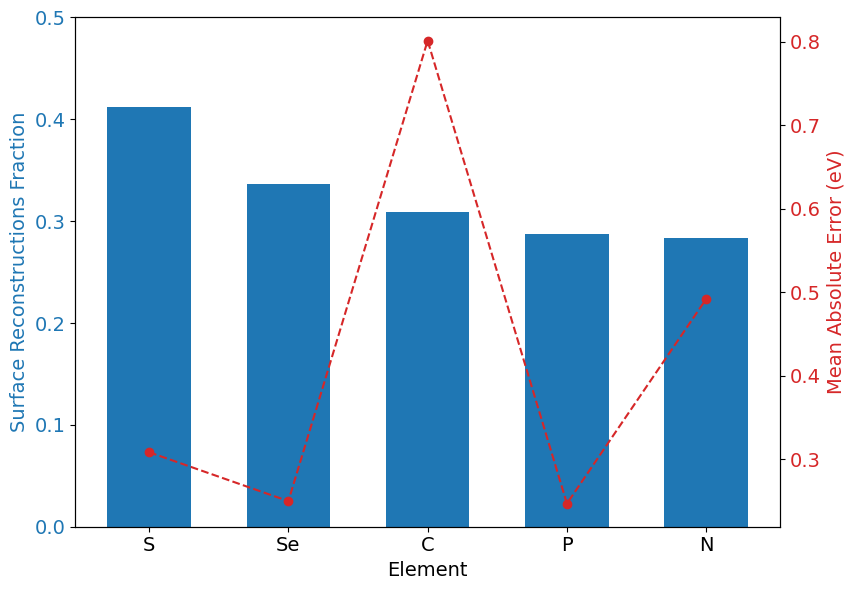

In [89]:
# Plotting the bar plot with mean errors
fig, ax1 = plt.subplots(figsize=(8, 6))
color = 'tab:blue' 
ax1.set_xlabel('Element', fontsize= 14)
ax1.set_ylabel('Surface Reconstructions Fraction' , color=color,fontsize= 14) 
ax1.bar(sorted_keys, sorted_surf_reconst , color=color, width = 0.6)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 0.5)
ax1.tick_params(axis='x', labelsize= 14)
ax1.tick_params(axis='y', labelsize= 14)
fig.tight_layout()  

# Create a second y-axis for element counts
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Mean Absolute Error (eV)', color=color, alpha = 1, fontsize= 14)
ax2.plot(sorted_keys, sorted_errors, color=color, linestyle='--', marker='o')
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(0, 0.9)
ax2.tick_params(axis='x', labelsize= 14)
ax2.tick_params(axis='y', labelsize= 14)
plt.show()